<a href="https://colab.research.google.com/github/ManjuRama/MSFE/blob/main/ML_GWP_1_4729.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Student Group 4729**



## STEP 2 - Category 2 - K-Means Clustering##

In [ ]:
# Base Libraries
import pandas as pd
import numpy as np
import missingno
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

plt.style.use('fivethirtyeight')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import ridge, lasso and elastic nets regression from sklearn library
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Import GridSearchCV and RepeatedKFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold

In [ ]:
# Set display options
#pd.set_option('display.max_rows', 5000)
#pd.set_option('display.max_columns', 5000)
#pd.set_option('display.width', 1000)

In [ ]:
snp = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')


In [ ]:
snp[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [ ]:
# Retrieve stock symbol
snp_stocks = list(snp[0]['Symbol'])
snp_company_name = list(snp[0]['Security'])
snp_stocks[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [ ]:
# Store stock prices in a dataframe
snp_ohlc = {symbol: yf.download(symbol, start='2020-01-01', end='2023-11-30', auto_adjust=True, progress=False) for symbol in snp_stocks}

# Save dow_ohlc dict for future use
np.save('snp_ohlc.npy', snp_ohlc)

# Load down_ohlc dict
#snp_ohlc = np.load('data/dow_ohlc.npy', allow_pickle='TRUE').item()
#snp_ohlc['MMM'].head()

stock_price = pd.DataFrame({symbol: snp_ohlc[symbol]['Close'] for symbol in snp_stocks}, index= pd.date_range(start="2020-01-01",end="2023-11-30"))
stock_price.fillna(method='ffill', axis=0, inplace=True)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2023-11-30)')


In [ ]:
# Check for missing values

# Fill backward the missing values
stock_price.fillna(method='bfill', axis=0, inplace=True)

# Manipulate stock price dataframe: WEEKLY resample
weekly_return = stock_price.resample('W-FRI').last().pct_change()
weekly_return = weekly_return.T


# Create dataframe to hold cluster details
dfSNP = pd.DataFrame({'Ticker': snp_stocks,
                    'STDDEV': weekly_return.std(axis=1),
                    'RETURN': weekly_return.mean(axis=1)}
                  )

dfSNP = dfSNP.reset_index(drop=True)
dfSNP.dropna (inplace = True)

dfSNP.head (10)

,Ticker,STDDEV,RETURN
0,MMM,0.036964,-0.001404
1,AOS,0.044100,0.003595
2,ABT,0.038247,0.001984
3,ABBV,0.035597,0.003704
4,ACN,0.040999,0.003391
5,ADBE,0.052336,0.004438
6,AMD,0.071237,0.007065
7,AES,0.056605,0.001510
8,AFL,0.049612,0.003827
9,A,0.038554,0.002882


In [ ]:
# Import sklearn modules
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# import yfinance as yf
from datetime import datetime

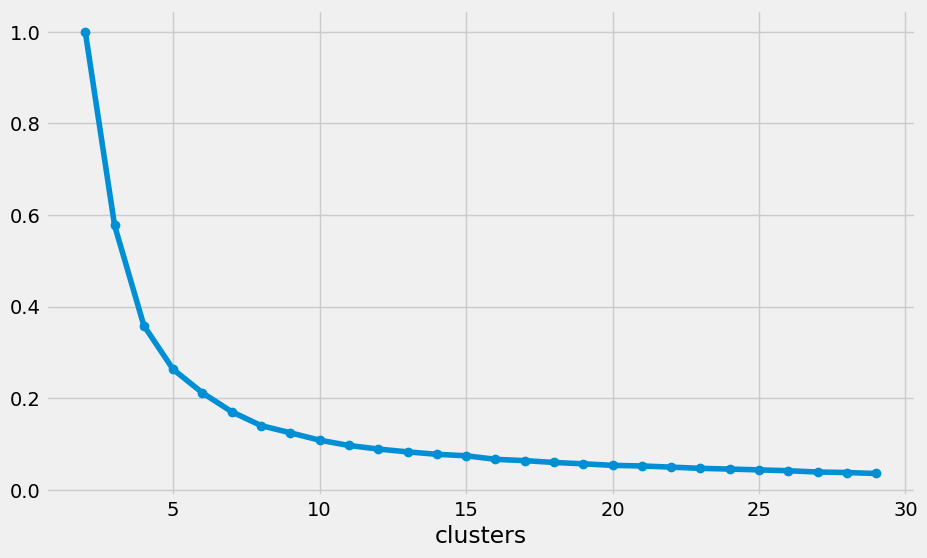

In [ ]:
n_clusters = range(2, 30)
inertia = []

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(dfSNP[['RETURN', 'STDDEV']])
    inertia.append(kmeans.inertia_)

plt.plot(n_clusters, np.divide(inertia,inertia[0]), "o-")

plt.xlabel('clusters');


In [ ]:
# Normalize and fit the model
kmeans = np.empty(2, dtype=object)
for i in range (2):
  if i == 0:
    kmeans [i] = Pipeline([("normalization", StandardScaler()), ("cluster", KMeans(n_clusters=7, init="k-means++", max_iter=300, n_init=10, random_state=0))])
  elif i == 1:
    kmeans [i] = Pipeline([("normalization", MinMaxScaler()), ("cluster", KMeans(n_clusters=7, init="k-means++", max_iter=300, n_init=10, random_state=0))])

  # Fit Model
  kmeans[i].fit(dfSNP[['RETURN', 'STDDEV']])

  # Assign Label

  dfSNP['Target' + str (i) ] = kmeans[i].predict(dfSNP[['RETURN', 'STDDEV']])
  dfSNP.head()

In [ ]:
dfSNP

,Ticker,STDDEV,RETURN,Target0,Target1
0,MMM,0.036964,-0.001404,6,5
1,AOS,0.044100,0.003595,5,0
2,ABT,0.038247,0.001984,1,6
3,ABBV,0.035597,0.003704,5,0
4,ACN,0.040999,0.003391,5,0
...,...,...,...,...,...
498,YUM,0.042231,0.002281,1,6
499,ZBRA,0.057012,0.001225,3,3
500,ZBH,0.045784,0.000029,6,5
501,ZION,0.068571,0.001171,4,2


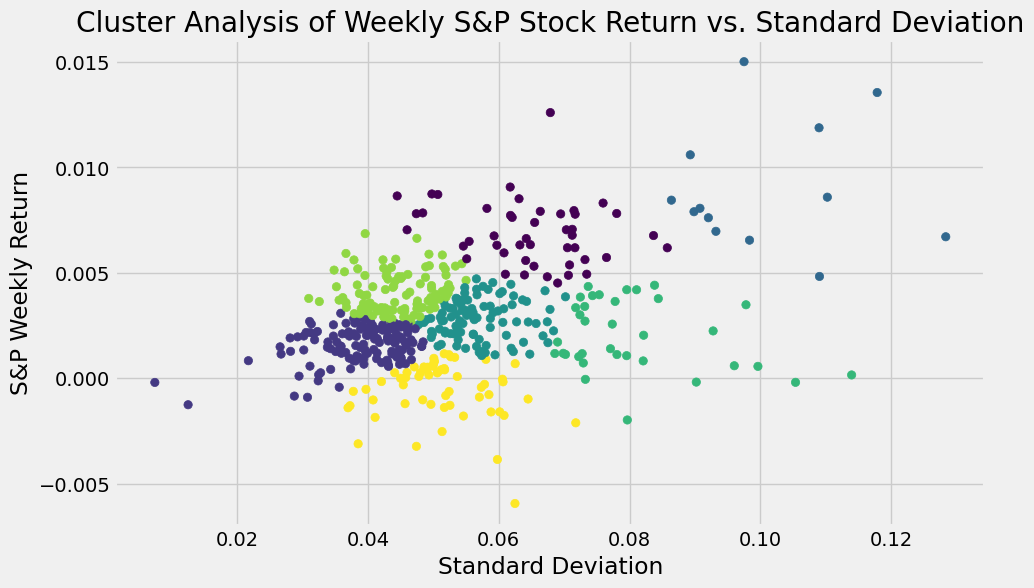

In [ ]:
# Train plot
for i in range (1):
  centers = kmeans[i]['cluster'].cluster_centers_
  plt.scatter(dfSNP['STDDEV'], dfSNP['RETURN'], c=dfSNP['Target' + str(i)])
  #plt.scatter(centers[:,0], centers[:,1], c='red', s=100, marker='x')
  #plt.scatter( centers[:, 1], centers[:, 0], s=50, c="black")
  #plt.scatterplot(x=model.cluster_centers_[:,10], y=model.cluster_centers_[:,13], color='blue',marker='*', label='centroid', s=250
  plt.xlabel('Standard Deviation')
  plt.ylabel('S&P Weekly Return')
  plt.title('Cluster Analysis of Weekly S&P Stock Return vs. Standard Deviation')
  plt.show()

## STEP 2 - Category 1 - Elastic Nets##

In [ ]:
# Getting historical market data from META (Faceebook)
# Calculate returns and clean data by removing unnecessary columns

df = yf.download("META", start="2000-01-01", end="2022-01-01")

df["Ret"] = df["Adj Close"].pct_change()

name = "Ret"
df["Ret10_i"] = (
    df[name].rolling(10).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1 / 10) - 1))
)
df["Ret25_i"] = (
    df[name].rolling(25).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1 / 25) - 1))
)
df["Ret60_i"] = (
    df[name].rolling(60).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1 / 60) - 1))
)
df["Ret120_i"] = (
    df[name].rolling(120).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1 / 120) - 1))
)
#df["Ret240_i"] = (
 #   df[name].rolling(240).apply(lambda x: 100 * ((np.prod(1 + x)) ** (1 / 240) - 1))
#)

del df["Open"]
del df["Close"]
del df["High"]
del df["Low"]
del df["Volume"]
del df["Adj Close"]

#Remove rows with NA and display last 10 entries
df = df.dropna()
df.tail(10)

[*********************100%%**********************]  1 of 1 completed


,Ret,Ret10_i,Ret25_i,Ret60_i,Ret120_i
Date,,,,,
2021-12-17,-0.003314,0.845410,0.073193,-0.059667,-0.043996
2021-12-20,-0.024986,0.235942,-0.185232,-0.135152,-0.055118
2021-12-21,0.026886,0.347359,-0.156668,-0.093906,-0.048870
2021-12-22,-0.011221,-0.003328,-0.148523,-0.050654,-0.058997
2021-12-23,0.014495,0.163129,-0.065423,-0.021583,-0.042489
2021-12-27,0.032633,0.487425,0.087533,0.033020,-0.010311
2021-12-28,0.000116,0.345269,0.010644,0.015526,0.001373
2021-12-29,-0.009474,0.272303,0.022577,0.083289,-0.017979
2021-12-30,0.004141,0.078746,0.083487,0.056124,-0.021026


In [ ]:
# Separating the inputs features (X) and the target variables (Y)

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]
print(X.shape, y.shape)

# Splitting dataset into training and testing subsets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=int(len(y) * 0.5), shuffle=False
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2302, 4) (2302,)
(1151, 4) (1151, 4) (1151,) (1151,)


In [ ]:
# Running Ridge regression and determining the coefficients

ridgeR = Ridge(alpha=0.7)
ridgeR.fit(X_train, y_train)
y_pred_ridge = ridgeR.predict(X_train)
y_pred_test_ridge = ridgeR.predict(X_test)

# calculate mean squared error
mean_squared_error = np.mean((y_pred_test_ridge - y_test) ** 2)
print("Mean squared error on test set", mean_squared_error)

Mean squared error on test set 0.013901728979044068


In [ ]:
# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"] = X_train.columns
ridge_coefficient["Coefficient Estimate"] = pd.Series(ridgeR.coef_)
print(ridge_coefficient)

   Columns  Coefficient Estimate
0      Ret             -0.040570
1  Ret10_i              0.019092
2  Ret25_i             -0.043279
3  Ret60_i              0.321394


In [ ]:
# Running Lasso Regression
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)
y_pred_Lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

# Calculate Mean Squared Error
mean_squared_error = np.mean((y_pred_test_lasso - y_test) ** 2)
print("Mean squared error on test set", mean_squared_error, "\n")

#Determining the coefficients
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = X_train.columns
lasso_coeff["Coefficient Estimate"] = pd.Series(lasso.coef_)

print(lasso_coeff)

Mean squared error on test set 0.013871290861063208 

   Columns  Coefficient Estimate
0      Ret             -0.000000
1  Ret10_i              0.018050
2  Ret25_i             -0.042815
3  Ret60_i              0.322909


In [ ]:
# Running Elastic Nets regression assuming alpha = 0.001 and l1_ratio = 0.1
# Train the model
e_net = ElasticNet(alpha=0.0001, l1_ratio=0.1)
e_net.fit(X_train, y_train)

# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(X_test)
mean_squared_error = np.mean((y_pred_elastic - y_test) ** 2)
print("Mean Squared Error on test set", mean_squared_error, "\n")

#Determining the coefficients
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = X_train.columns
e_net_coeff["Coefficient Estimate"] = pd.Series(e_net.coef_)
e_net_coeff

Mean Squared Error on test set 0.013875723811047746 



,Columns,Coefficient Estimate
0,Ret,-0.061620
1,Ret10_i,0.019460
2,Ret25_i,-0.045011
3,Ret60_i,0.325209


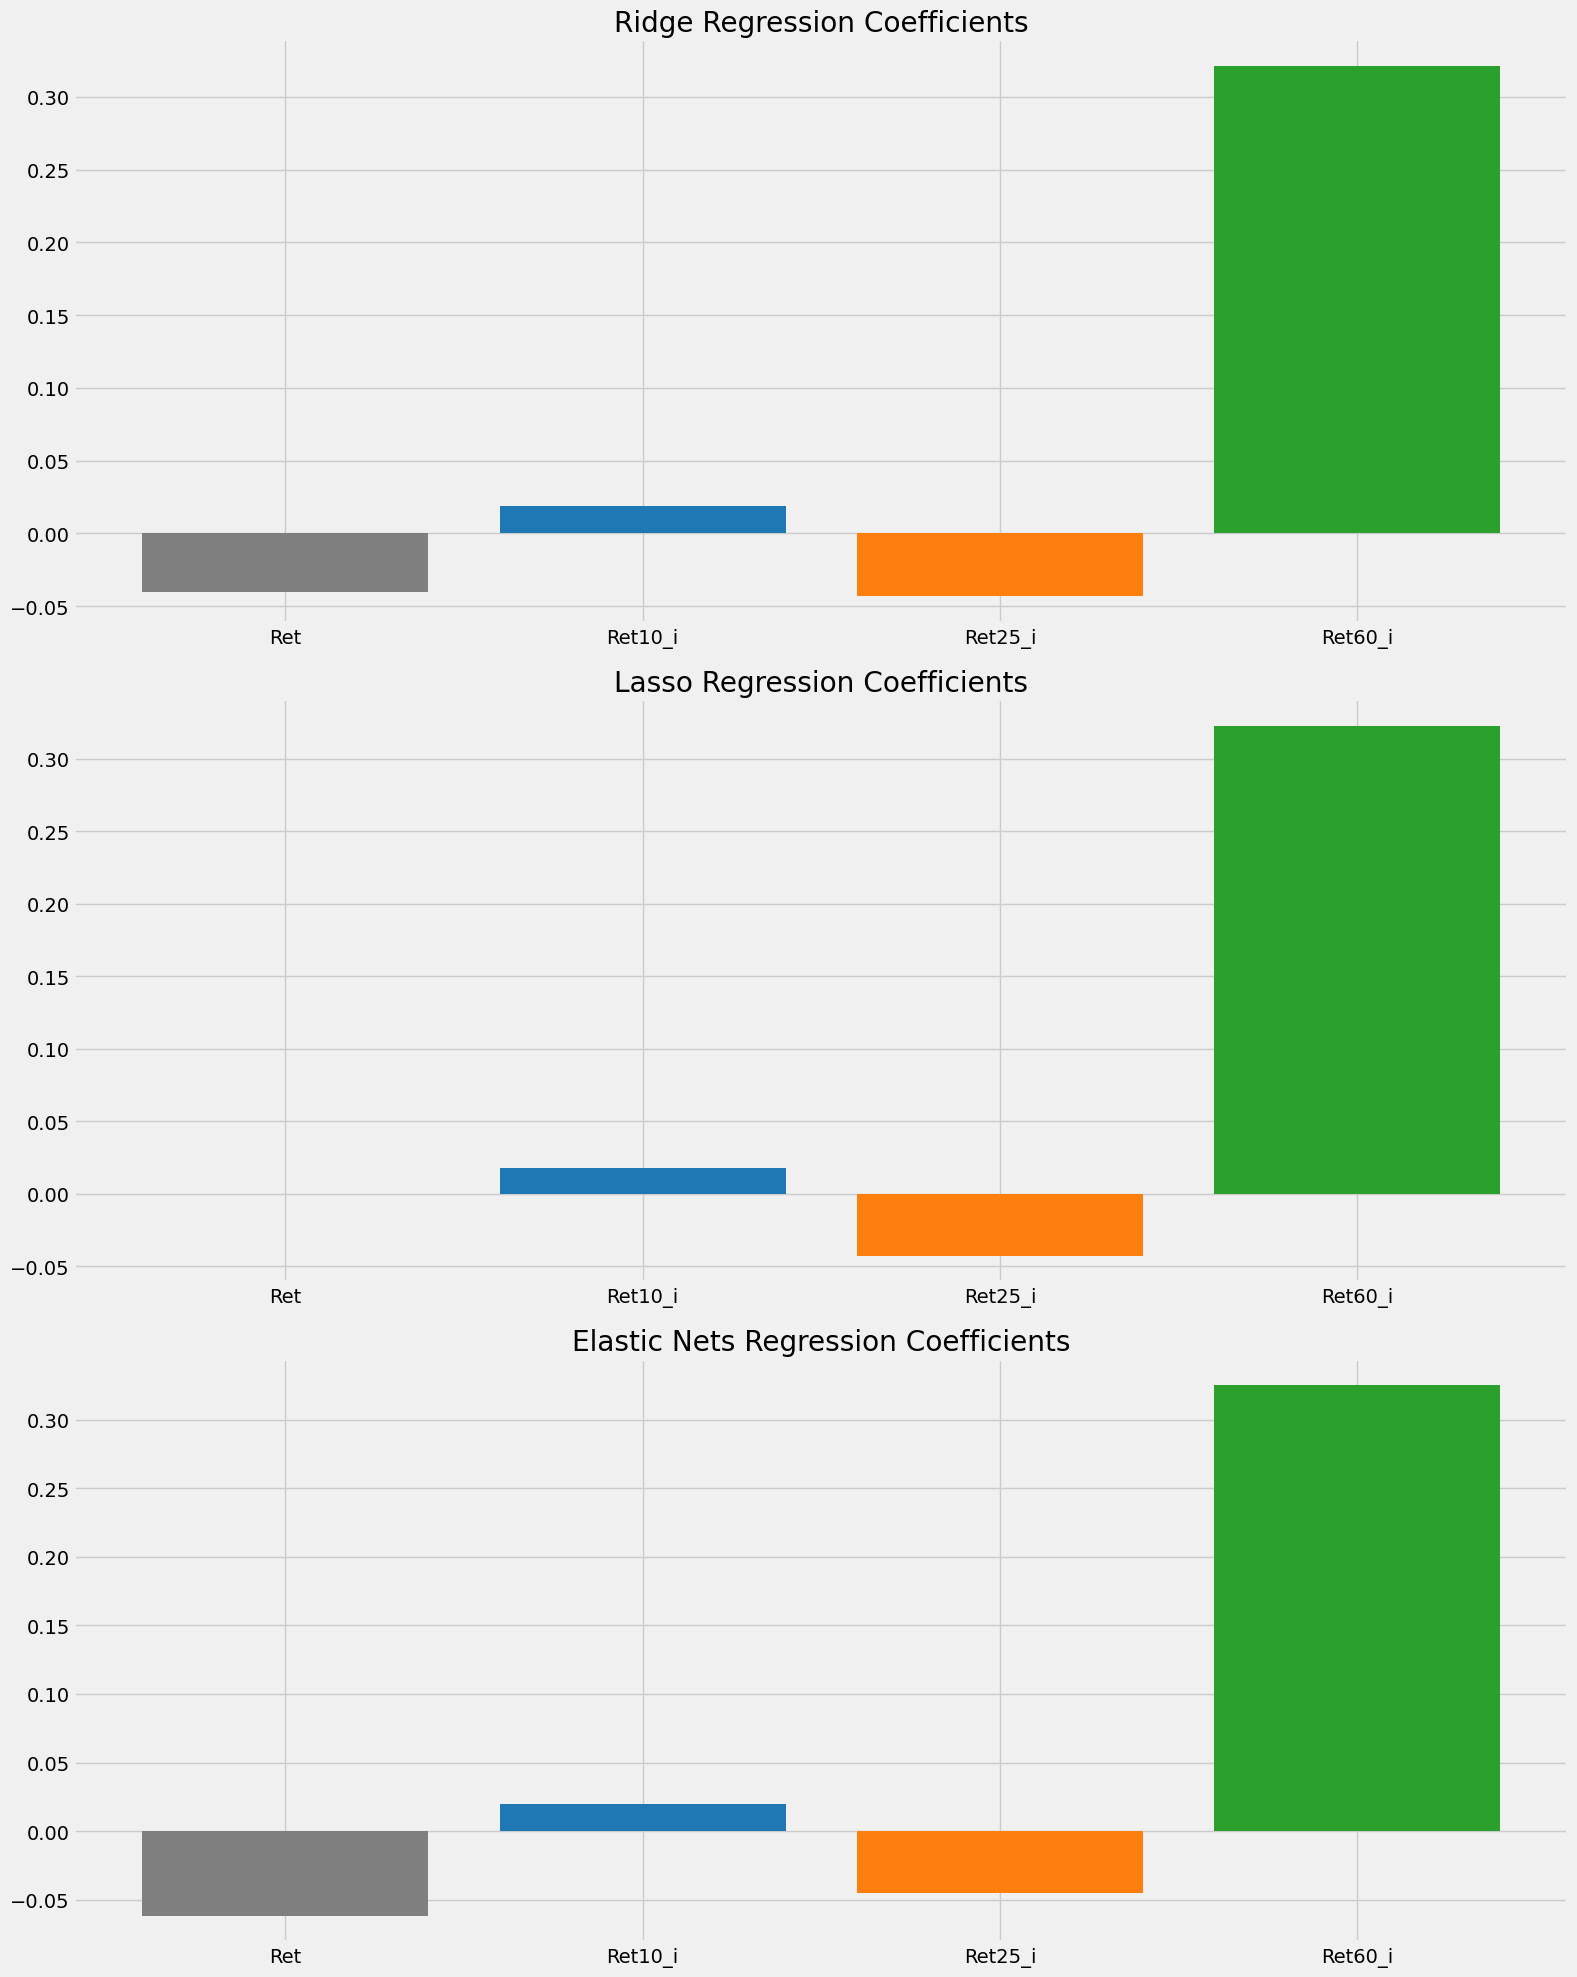

In [ ]:
# Plotting coefficients for the Ridge, Lasso and Elastic nets regressions

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 20))

colors = [
    "tab:gray",
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:orange",
    "tab:green",
    "tab:blue",
    "tab:olive",
]

# Plot the first regression
axes[0].bar(ridge_coefficient["Columns"], ridge_coefficient["Coefficient Estimate"], color=colors)
axes[0].set_title("Ridge Regression Coefficients")

# Plot the second regression
axes[1].bar(lasso_coeff["Columns"], lasso_coeff["Coefficient Estimate"], color=colors)
axes[1].set_title("Lasso Regression Coefficients")

# Plot the third regression
axes[2].bar(e_net_coeff["Columns"], e_net_coeff["Coefficient Estimate"], color=colors)
axes[2].set_title("Elastic Nets Regression Coefficients")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid["alpha"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
grid["l1_ratio"] = [0, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
search = GridSearchCV(model, grid, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print("MSE: %.3f" % results.best_score_)
print("Config: %s" % results.best_params_)

MSE: -0.022
Config: {'alpha': 0.0001, 'l1_ratio': 1}


In [ ]:
# Train the model
e_net = ElasticNet(alpha=0.0001, l1_ratio=1)  # Using the above hyperparameters
e_net.fit(X_train, y_train)

# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(X_test)
mean_squared_error = np.mean((y_pred_elastic - y_test) ** 2)
print("Mean Squared Error on test set", mean_squared_error)

Mean Squared Error on test set 0.013871290861063208


## Step 2 Category 3 - Principal Components


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import yfinance as yf

[*********************100%%**********************]  5 of 5 completed


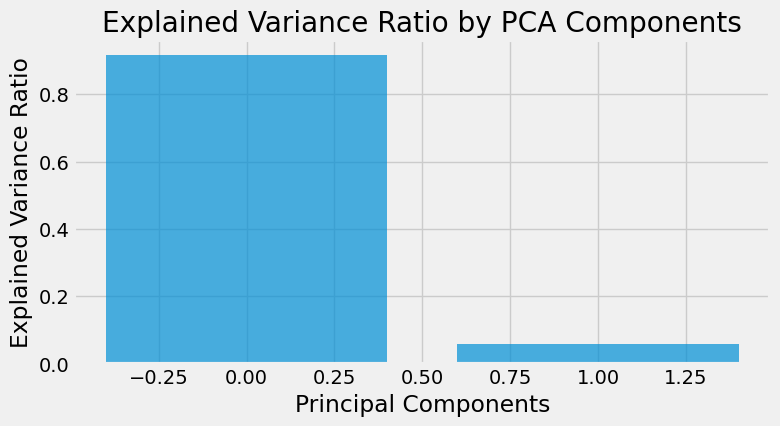

   Principal Component 1  Principal Component 2
0               2.273819               0.660275
1               2.376841               0.672323
2               2.199283               0.810093
3               2.232501               0.812470
4               2.121492               0.850788
Explained variance by each component: [0.91638447 0.05670499]


In [ ]:
#Fetch data from yahoo

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']  # Replace with your chosen tickers
data = yf.download(tickers, start="2020-01-01", end="2021-01-01")['Adj Close']

# Handling missing values
data = data.dropna()

# Standardizing the data
scaler = StandardScaler()
data_std = scaler.fit_transform(data)

# Applying PCA
pca = PCA(n_components=2)  # Reduce the data to 2 dimensions
principalComponents = pca.fit_transform(data_std)

# Creating a DataFrame for the principal components
principalDf = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plotting the explained variance
plt.figure(figsize=(8, 4))
plt.bar(range(2), explained_variance, alpha=0.7)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance Ratio by PCA Components')
plt.show()

# Displaying the first few rows of the transformed dataset
print(principalDf.head())

# Displaying the explained variance ratios
print("Explained variance by each component:", explained_variance)

**Explained Variance Ratio Bar Chart**
The above bar chart shows the explained variance ratio of the PCA components. The explained variance ratio indicates the proportion of the dataset's total variance that is 'explained' by each principal component. In the chart, the first principal component explains a substantial amount of variance(over 90%), which suggests that this component captures most of the variability in the data.

**Principal Components DataFrame**
Below the chart, there is a dataframe displaying the first five entries of the transformed dataset. This Dataframe has two columns: Principal Component 1 and Principal Component 2, which are the coordinates of the original data in the new feature space defined by the first two principal components.

**Explained Variance by Each Component**
At the bottom, you see actual numerical values of the explained variance ratio for each of the two principal components. The first principal component has an explained variance ration of approximately 0.916( or 91.6%), which the second component has an explained variance of about 0.057( or 5.7%). This is confirmed by the bar chart.

The high explained variance by the first component suggests that the second component adds relatively little information beyond what is captured by the first. This is typical in scenarios where one factor(like market trend) might explain a large part of the variance in teh stock prices, and other factors(like individual company performance) play a lesser role. In financial terms, if these components were derived from stock price data, the first principal component might represent a market factor affecting all stocks similarly, while the second component could represent more specific influences that affect the stocks in a more varied way.